### Submitted by:
Venkat Mohit Sornapudi - 2721697

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [2]:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    return sig

# Part 2: Scalar backpropagation

## Question 3.

![alt text](nn.png "nn")

In [3]:
x = [1,-1]
a = [0]*3
w = [[1., 1., 1.], [-1., -1., -1.]]
k = [0]*3
h = [0]*3
b = [0]*2
v = [[1,1],[-1,-1],[-1,-1]]
o = [0]*2
y = [0]*2
sum_o = 0
c = 0

for j in range(3):
    for i in range(2):
        k[j] += w[i][j] * x[i]
    k[j] += a[j]
for i in range(3):
    h[i] = sigmoid(k[i])
for j in range(2):
    for i in range(3):
        o[j] += v[i][j] * h[i]
    o[j] += b[j]
for i in range(2):
    sum_o += math.exp(o[i])
for i in range(2):
    y[i] += math.exp(o[i])/sum_o
loss = -math.log(y[c])

In [4]:
grad_a = [0]*3
grad_w = [[0]*3]*2
grad_k = [0]*3
grad_h = [0]*3
grad_b = [0]*2
grad_v = [[0]*2]*3
grad_o = [0]*2
grad_y = [0]*2

for i in range(2):
    if i==c:
        grad_y[i] = -1/y[c]
    else:
        grad_y[i] = 0
for j in range(2):
    if j==c:
        grad_o[j] = y[i] - 1
    else:
        grad_o[j] = y[i]
for j in range(2):
    for i in range(3):
        grad_v[i][j] = grad_o[j] * h[i]
        grad_h[i] += grad_o[j] * v[i][j]
    grad_b[j] = grad_o[j]
for i in range(3):
    grad_k[i] = grad_h[i] * h[i] * (1-h[i])
for j in range(3):
    for i in range(2):
        grad_w[i][j] = grad_k[j] * x[i]
    grad_a[j] = grad_k[j]

In [5]:
grad_w

[[-0.0, -0.0, -0.0], [-0.0, -0.0, -0.0]]

In [6]:
grad_a

[0.0, 0.0, 0.0]

In [7]:
grad_v

[[-0.44039853898894116, 0.44039853898894116],
 [-0.44039853898894116, 0.44039853898894116],
 [-0.44039853898894116, 0.44039853898894116]]

In [8]:
grad_b

[-0.5, 0.5]

# Data loading

In [9]:
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

# Question 4.

In [10]:
(xtrain, ytrain), (xval, yval), num_cls = load_synth()

In [11]:
loss = []
a = [0]*3
w = [[1., 1., 1.], [-1., -1., -1.]]
k = [0]*3
h = [0]*3
b = [0]*2
v = [[1,1],[-1,-1],[-1,-1]]
o = [0]*2
y = [0]*2
sum_o = 0
grad_a = [0]*3
grad_w = [[0]*3]*2
grad_k = [0]*3
grad_h = [0]*3
grad_b = [0]*2
grad_v = [[0]*2]*3
grad_o = [0]*2
grad_y = [0]*2

In [12]:
for i in range(ytrain.size):
    x = list(xtrain[i])
    c = ytrain[i]

    #forward
    for j in range(3):
        for i in range(2):
            k[j] += w[i][j] * x[i]
        k[j] += a[j]
    for i in range(3):
        h[i] = sigmoid(k[i])
    for j in range(2):
        for i in range(3):
            o[j] += v[i][j] * h[i]
        o[j] += b[j]
    for i in range(2):
        sum_o += np.exp(round(o[i], 2))
    for i in range(2):
        y[i] += np.exp(o[i])/sum_o
    loss.append(-math.log(y[c]))
    
    #backward
    for j in range(2):
        if j==c:
            grad_o[j] = y[i] - 1
        else:
            grad_o[j] = y[i]
    for j in range(2):
        for i in range(3):
            grad_v[i][j] = grad_o[j] * h[i]
            grad_h[i] += grad_o[j] * v[i][j]
        grad_b[j] = grad_o[j]
    for i in range(3):
        grad_k[i] = grad_h[i] * h[i] * (1-h[i])
    for j in range(3):
        for i in range(2):
            grad_w[i][j] = grad_k[j] * x[i]
        grad_a[j] = grad_k[j]
        
    # weights update
    for j in range(3):
        for i in range(2):
            w[i][j] = w[i][j] - 0.01* grad_w[i][j]
        a[j] = a[j] - 0.01 * grad_a[j]
    for j in range(2):
        for i in range(3):
            v[i][j] = v[i][j] - 0.01* grad_v[i][j]
        b[j] = b[j] - 0.01 * grad_b[j]

C:\Users\Admin\Anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


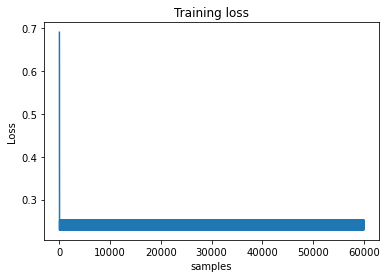

In [13]:
plt.plot(range(len(loss)), loss)
plt.xlabel('samples')
plt.ylabel('Loss') 
plt.title('Training loss')
plt.show()

# Part 3: Tensor backpropagation

## Question 5.

In [52]:
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()

In [53]:
xtrain.shape, ytrain.shape

((55000, 784), (55000,))

In [54]:
xtrain_norm = (xtrain/np.max(xtrain))

In [55]:
xval_norm = (xval/np.max(xtrain))

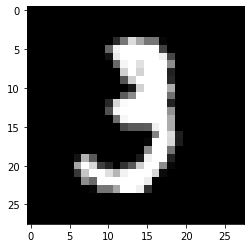

In [18]:
img = xtrain_norm[10].reshape(28,28)
plt.imshow(img,cmap='gray')
plt.show()

In [20]:
def CEloss(x,y):
    y_onehot = np.zeros_like(x)
    y_onehot[y] = 1
    loss = -math.log(np.dot(x,y_onehot))
    grad_loss = x - y_onehot # derviative for softmax
    return loss, grad_loss

In [58]:
def forward_pass(w,v,x):
    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x)
        return e_x / e_x.sum()

    k = w.dot(x) # k=wx+b
    h = sigmoid(k) # layer 1 out
    h = np.append(h, 1) 
    o = v.dot(h) # o=vh+b
    y = softmax(o) # layer 2 out
    return y,h,k

In [22]:
def backward_pass(grad_loss,h,v,k,x):
    grad_o = grad_loss.reshape(-1,1)
    h = h.reshape(1,-1)
    grad_v = np.matmul(grad_o, h) # layer 2 grad weights
    grad_h = np.dot(grad_o.T,v)
    grad_h = grad_h[:,:-1] 
    grad_k = grad_h*sigmoid(k)*(1 - sigmoid(k)) 
    grad_k = grad_k.reshape(-1,1)
    x = x.reshape(1,-1)
    grad_w = np.matmul(grad_k,x) # layer 1 gard weights
    return grad_w, grad_v

In [59]:
def run_SGD(learning_rate=0.001):

    # Xavier’s initialization
    w = np.random.rand(300,xtrain[0].size+1)*np.sqrt(1/(728+300))
    v = np.random.rand(num_cls,300+1)*np.sqrt(1/(300+10))

    epoch_train_loss = np.zeros((5))
    epoch_val_loss = np.zeros((5))
    train_accuracy = np.zeros((5))
    val_accuracy = np.zeros((5))

    for epoch in np.arange(5): 
        train_loss = []
        val_loss = []
        y_train_pred = []
        y_val_pred = []

        for i in np.arange(xtrain_norm.shape[0]):
            x = xtrain_norm[i]
            digit = ytrain[i]
            x = np.append(x, 1)

            y,h,k = forward_pass(w,v,x)
            y_train_pred.append(np.argmax(y))

            #loss
            loss_sample, grad_loss = CEloss(y, digit)
            train_loss.append(loss_sample) 

            grad_w, grad_v = backward_pass(grad_loss,h,v,k,x)

            #weights update
            w = w - learning_rate*grad_w
            v = v - learning_rate*grad_v

        for i in np.arange(xval_norm.shape[0]):
            x = xval_norm[i]
            digit = yval[i]
            x = np.append(x, 1)
            y,h,k = forward_pass(w,v,x)
            y_val_pred.append(np.argmax(y))
            loss_sample, grad_loss = CEloss(y, digit)
            val_loss.append(loss_sample)

        ep_loss = np.sum(train_loss)/(xtrain_norm.shape[0])
        epoch_train_loss[epoch] = ep_loss
        ep_loss = np.sum(val_loss)/(xval_norm.shape[0])
        epoch_val_loss[epoch] = ep_loss

        acc = (np.array(y_train_pred) == ytrain).mean()
        train_accuracy[epoch] = acc 
        acc = (np.array(y_val_pred) == yval).mean()
        val_accuracy[epoch] = acc  
    
    return epoch_train_loss, epoch_val_loss, train_accuracy, val_accuracy

In [24]:
epoch_train_loss, epoch_val_loss, train_accuracy, val_accuracy = run_SGD()

for i in np.arange(5):
    print("Epoch {} |  Training Loss: {}  Training ACC: {}".format(i,epoch_train_loss[i],train_accuracy[i]))
    print("         |  Validation Loss: {}  Validation ACC: {}".format(i,epoch_val_loss[i],val_accuracy[i]))
    print("")

Epoch 0 |  Training Loss: 1.8347528022263917  Training ACC: 0.37427272727272726
         |  Validation Loss: 0  Validation ACC: 0.8529712360667596

Epoch 1 |  Training Loss: 0.6226673649865966  Training ACC: 0.8331272727272727
         |  Validation Loss: 1  Validation ACC: 0.3895404306463048

Epoch 2 |  Training Loss: 0.4174274986437919  Training ACC: 0.8852727272727273
         |  Validation Loss: 2  Validation ACC: 0.3033353966464058

Epoch 3 |  Training Loss: 0.35913968572683913  Training ACC: 0.8994363636363636
         |  Validation Loss: 3  Validation ACC: 0.27066627472547505

Epoch 4 |  Training Loss: 0.3305666631410923  Training ACC: 0.9057272727272727
         |  Validation Loss: 4  Validation ACC: 0.25294625990673425



# Part 4: Analysis

## Question 7.

### 1.

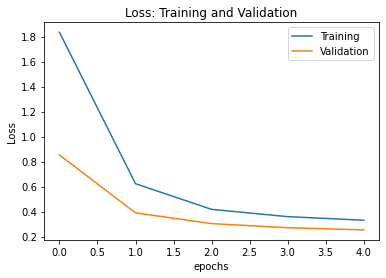

In [25]:
plt.plot(epoch_train_loss, label='Training')
plt.plot(epoch_val_loss, label='Validation')
plt.title('Loss: Training and Validation')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

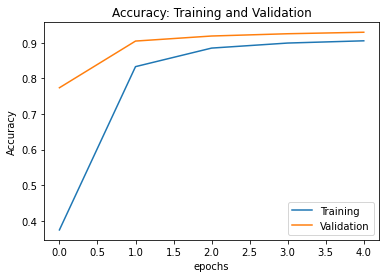

In [26]:
plt.plot(train_accuracy, label='Training')
plt.plot(val_accuracy, label='Validation')
plt.title('Accuracy: Training and Validation')
plt.xlabel('epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

### 2.

In [60]:
epoch_train_loss, epoch_val_loss, train_accuracy, val_accuracy = {}, {}, {}, {}
t = np.arange(1,4)
for run in t:
    epoch_train_loss[run], epoch_val_loss[run], train_accuracy[run], val_accuracy[run] = run_SGD()

In [61]:
epoch_train_loss = np.array(list(epoch_train_loss.values()))
epoch_val_loss = np.array(list(epoch_val_loss.values()))
train_accuracy = np.array(list(train_accuracy.values()))
val_accuracy = np.array(list(val_accuracy.values()))

In [62]:
epoch_train_loss.shape

(3, 5)

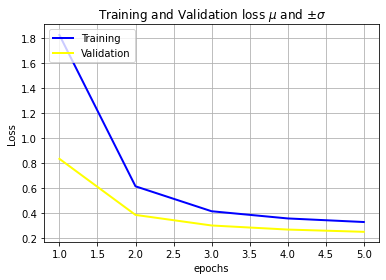

In [65]:
mu1 = epoch_train_loss.mean(axis=0)
sigma1 = epoch_train_loss.std(axis=0)
mu2 = epoch_val_loss.mean(axis=0)
sigma2 = epoch_val_loss.std(axis=0)
t1 = np.arange(1,6)

fig, ax = plt.subplots(1)
ax.plot(t1, mu1, lw=2, label='Training', color='blue')
ax.plot(t1, mu2, lw=2, label='Validation', color='yellow')
ax.fill_between(t1, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.fill_between(t1, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
ax.set_title(r'Training and Validation loss $\mu$ and $\pm \sigma$')
ax.legend(loc='upper left')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.grid()

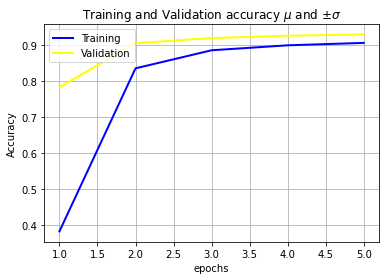

In [67]:
mu1 = train_accuracy.mean(axis=0)
sigma1 = train_accuracy.std(axis=0)
mu2 = val_accuracy.mean(axis=0)
sigma2 = val_accuracy.std(axis=0)

fig, ax = plt.subplots(1)
ax.plot(t1, mu1, lw=2, label='Training', color='blue')
ax.plot(t1, mu2, lw=2, label='Validation', color='yellow')
ax.fill_between(t1, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.fill_between(t1, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
ax.set_title(r'Training and Validation accuracy $\mu$ and $\pm \sigma$')
ax.legend(loc='upper left')
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.grid()

### 3.

In [31]:
epoch_train_loss, epoch_val_loss, train_accuracy, val_accuracy = {}, {}, {}, {}
learning_rates = ["0.001", "0.003", "0.01", "0.03"]
for lr in learning_rates:
    epoch_train_loss[lr], epoch_val_loss[lr], train_accuracy[lr], val_accuracy[lr] = run_SGD(learning_rate=float(lr))

In [32]:
epoch_train_loss = np.array(list(epoch_train_loss.values()))
epoch_val_loss = np.array(list(epoch_val_loss.values()))
train_accuracy = np.array(list(train_accuracy.values()))
val_accuracy = np.array(list(val_accuracy.values()))

In [33]:
epoch_train_loss

array([[1.8108828 , 0.61128732, 0.41586221, 0.35907024, 0.3305467 ],
       [0.95413488, 0.34055191, 0.29443684, 0.26522321, 0.24044178],
       [0.53157472, 0.2508248 , 0.18716669, 0.14735335, 0.12079287],
       [0.34497763, 0.13611664, 0.09060553, 0.06650653, 0.05073452]])

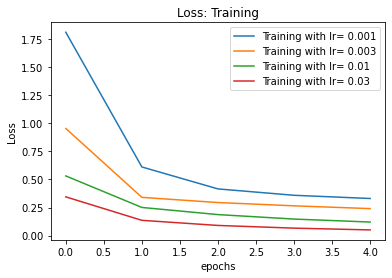

In [34]:
for i in range(len(learning_rates)):
    plt.plot(epoch_train_loss[i], label=f'Training with lr= '+learning_rates[i])
plt.title('Loss: Training')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

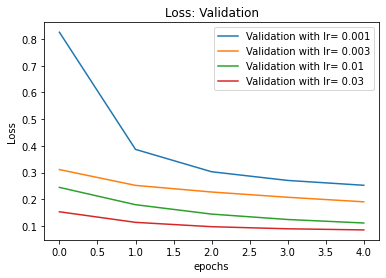

In [35]:
for i in range(len(learning_rates)):
    plt.plot(epoch_val_loss[i], label=f'Validation with lr= '+learning_rates[i])
plt.title('Loss: Validation')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.

In [36]:
(xtrain, ytrain), (xtest, ytest), num_cls = load_mnist(final=True)

In [37]:
xtrain_norm = (xtrain/np.max(xtrain))
xtest_norm = (xtest/np.max(xtrain))
learning_rate = 0.03

In [38]:
# Xavier’s initialization
w = np.random.rand(300,xtrain[0].size+1)*np.sqrt(1/(728+300))
v = np.random.rand(num_cls,300+1)*np.sqrt(1/(300+10))

for epoch in np.arange(5): 
    for i in np.arange(xtrain_norm.shape[0]):
        x = xtrain_norm[i]
        digit = ytrain[i]
        x = np.append(x, 1)
        y,h,k = forward_pass(w,v,x)
        loss_sample, grad_loss = CEloss(y, digit)
        grad_w, grad_v = backward_pass(grad_loss,h,v,k,x)
        #weights update
        w = w - learning_rate*grad_w
        v = v - learning_rate*grad_v

train_pred = []
test_pred = []
train_loss = []
test_loss = []

for i in np.arange(xtrain_norm.shape[0]):
    x = xtrain_norm[i]
    digit = ytrain[i]
    x = np.append(x, 1)
    y,h,k = forward_pass(w,v,x)
    train_pred.append(np.argmax(y))
    loss_sample, grad_loss = CEloss(y, digit)
    train_loss.append(loss_sample)
    
for i in np.arange(xtest_norm.shape[0]):
    x = xtest_norm[i]
    digit = ytest[i]
    x = np.append(x, 1)
    y,h,k = forward_pass(w,v,x)
    test_pred.append(np.argmax(y))
    loss_sample, grad_loss = CEloss(y, digit)
    test_loss.append(loss_sample)

train_loss = np.sum(train_loss)/(xtrain_norm.shape[0])
test_loss = np.sum(test_loss)/(xtest_norm.shape[0])

train_acc = (np.array(train_pred) == ytrain).mean() 
test_acc = (np.array(test_pred) == ytest).mean()

In [39]:
train_loss,test_loss,train_acc,test_acc

(0.0425528060001447, 0.07912055184606064, 0.9869833333333333, 0.9754)

## Question 6*.

In [68]:
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()

In [69]:
#normalize
xtrain_norm = xtrain.astype(np.float32)/255
xval_norm = xval.astype(np.float32)/255

In [70]:
batch_size = 32
n_batches = math.ceil(xtrain_norm.shape[0]/batch_size)
def get_batch(i,batch_size,xtrain_norm,ytrain):
    if i==n_batches-1:
        x_batched = xtrain_norm[i*batch_size:]
        y_batched = ytrain[i*batch_size:]
    else:
        x_batched = xtrain_norm[i*batch_size:(i+1)*batch_size]
        y_batched = ytrain[i*batch_size:(i+1)*batch_size]
    return x_batched, y_batched

In [71]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)

In [72]:
def CEloss_batch(x,y):
    y_onehot = np.eye(x.shape[1])[y]
    loss = - np.sum(np.log(np.sum(np.multiply(x,y_onehot), axis = 1)))/x.shape[0]
    grad_loss = (x-y_onehot)/x.shape[0] # derviative for softmax
    return loss, grad_loss

In [76]:
# Xavier’s initialization
w = np.random.rand(30,xtrain_norm[0].size+1)*np.sqrt(1/(728+30))
v = np.random.rand(10,30+1)*np.sqrt(1/(30+10))
train_epoch_loss = []
train_accuracy = []
val_epoch_loss = []
val_accuracy = []
for epoch in np.arange(20): 
    train_loss = []
    train_y_pred = []
    val_loss = []
    val_y_pred = []
    for batch_num in np.arange(n_batches):
        x_batch, digits_batch = get_batch(batch_num,batch_size,xtrain_norm,ytrain)
        x_batch = np.append(x_batch, np.ones((x_batch.shape[0],1)),axis=1)
        
        #forward
        k = np.matmul(x_batch,w.T) #
        h = sigmoid(k) #
        h = np.hstack([h, np.ones((h.shape[0],1))])
        o = np.matmul(h,v.T) #
        y = softmax(o) #
        train_y_pred.extend(np.argmax(y,axis=1))
        
        #loss
        loss_sample, grad_loss = CEloss_batch(y, digits_batch)
        train_loss.append(loss_sample) #

        #backward
        grad_o = grad_loss
        grad_v = np.matmul(grad_o.T, h)/x_batch.shape[0] #
        grad_h = np.matmul(grad_o, v)
        grad_h = grad_h[:,:-1]
        grad_k = grad_h*sigmoid(k)*(1 - sigmoid(k)) #
        grad_w = np.matmul(grad_k.T,x_batch)/x_batch.shape[0] #

        #weights update
        w -= 0.1*grad_w
        v -= 0.1*grad_v
        
    for batch_num in np.arange(n_batches):
        x_batch, digits_batch = get_batch(batch_num,batch_size,xval_norm,yval)
        x_batch = np.append(x_batch, np.ones((x_batch.shape[0],1)),axis=1)
        
        #forward
        k = np.matmul(x_batch,w.T) #
        h = sigmoid(k) #
        h = np.hstack([h, np.ones((h.shape[0],1))])
        o = np.matmul(h,v.T) #
        y = softmax(o) #
        val_y_pred.extend(np.argmax(y,axis=1))
        
        #loss
        loss_sample, grad_loss = CEloss_batch(y, digits_batch)
        val_loss.append(loss_sample) #
        
    train_ep_loss = np.sum(train_loss)/n_batches
    train_epoch_loss.append(train_ep_loss)
    val_ep_loss = np.sum(loss)/n_batches
    val_epoch_loss.append(val_ep_loss)
    
    train_acc = (np.array(train_y_pred) == ytrain).mean()
    train_accuracy.append(train_acc)
    val_acc = (np.array(val_y_pred) == yval).mean()
    val_accuracy.append(val_acc)
    
    print("Epoch {} |   Training Loss: {}   Training ACC: {}".format(epoch,train_ep_loss,train_acc))
    print("        |   Validation Loss: {}  Validation ACC: {}".format(epoch,val_ep_loss,val_acc))

C:\Users\Admin\Anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 0 |   Training Loss: 2.299043421263974   Training ACC: 0.11887272727272727
        |   Validation Loss: 0  Validation ACC: 0.5709259725141307
Epoch 1 |   Training Loss: 2.2901051602915787   Training ACC: 0.1824727272727273
        |   Validation Loss: 1  Validation ACC: 0.5709259725141307
Epoch 2 |   Training Loss: 2.2756355263680494   Training ACC: 0.27185454545454546
        |   Validation Loss: 2  Validation ACC: 0.5709259725141307
Epoch 3 |   Training Loss: 2.243102051924547   Training ACC: 0.35196363636363637
        |   Validation Loss: 3  Validation ACC: 0.5709259725141307
Epoch 4 |   Training Loss: 2.163833985131914   Training ACC: 0.4379818181818182
        |   Validation Loss: 4  Validation ACC: 0.5709259725141307
Epoch 5 |   Training Loss: 2.0145178984652903   Training ACC: 0.5211818181818182
        |   Validation Loss: 5  Validation ACC: 0.5709259725141307
Epoch 6 |   Training Loss: 1.8112480511960851   Training ACC: 0.5796909090909091
        |   Validation Loss: 6 

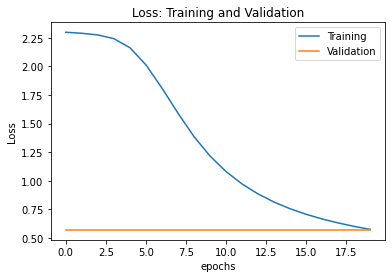

In [78]:
plt.plot(train_epoch_loss, label='Training')
plt.plot(val_epoch_loss, label='Validation')
plt.title('Loss: Training and Validation')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

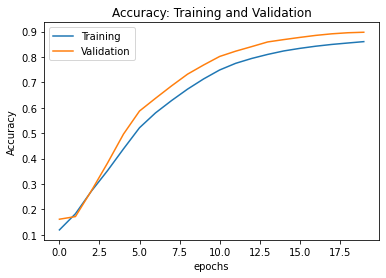

In [79]:
plt.plot(train_accuracy, label='Training')
plt.plot(val_accuracy, label='Validation')
plt.title('Accuracy: Training and Validation')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()